In [188]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
import numpy as np
from viz import plot_campaign_budgets, plot_opinions_over_time
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from algos import *

In [190]:
def create_adjacency_matrix_from_links(num_nodes, links):
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for link in links:
        from_node, to_node = link
        # adjacency_matrix[from_node, to_node] = 1
        adjacency_matrix[to_node, from_node] = 1

    return adjacency_matrix


def init_env():
    links = [
        (0, 2),
        (0, 4),
        (0, 5),
        (0, 6),
        (1, 3),
        (1, 8),
        (2, 0),
        (2, 1),
        (3, 0),
        (4, 0),
        (4, 5),
        (5, 4),
        (5, 10),
        (6, 4),
        (6, 9),
        (6, 11),
        (7, 5),
        (7, 8),
        (8, 1),
        (8, 5),
        (9, 6),
        (9, 12),
        (10, 5),
        (10, 7),
        (10, 13),
        (11, 5),
        (11, 6),
        (11, 7),
        (11, 14),
        (12, 8),
        (13, 5),
        (13, 11),
        (14, 5),
        (14, 11),
    ]

    num_nodes = 15
    connectivity_matrix = create_adjacency_matrix_from_links(num_nodes, links)
    # connectivity_matrix = normalize_adjacency_matrix(connectivity_matrix)

    initial_opinions = np.linspace(0, 1, num_nodes)

    env = NetworkGraph(
        connectivity_matrix=connectivity_matrix,
        initial_opinions=initial_opinions,
        max_u=0.2,
        budget=100.0,
        desired_opinion=1.0,
        tau=0.5,
        max_steps=1_000_000,
    )

    env.reset()

    return env

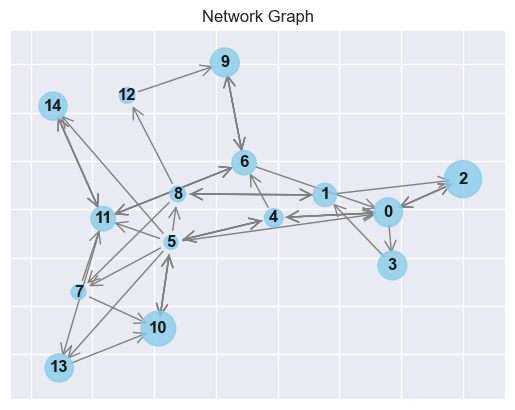

In [191]:
env = init_env()
env.render(mode="matplotlib")

c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\rl_envs_forge\envs\network_graph\visualize.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_labels, y=sorted_centralities, palette="Blues_d")


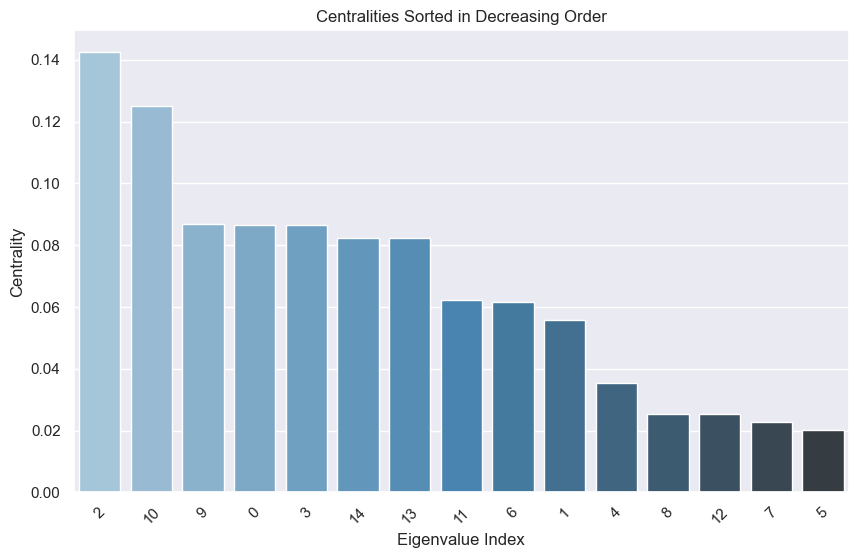

In [192]:
env.render(mode="centralities")

## Zero control 

Overall Error: 0.5079612001655786
Final Error: 0.5134870962840572


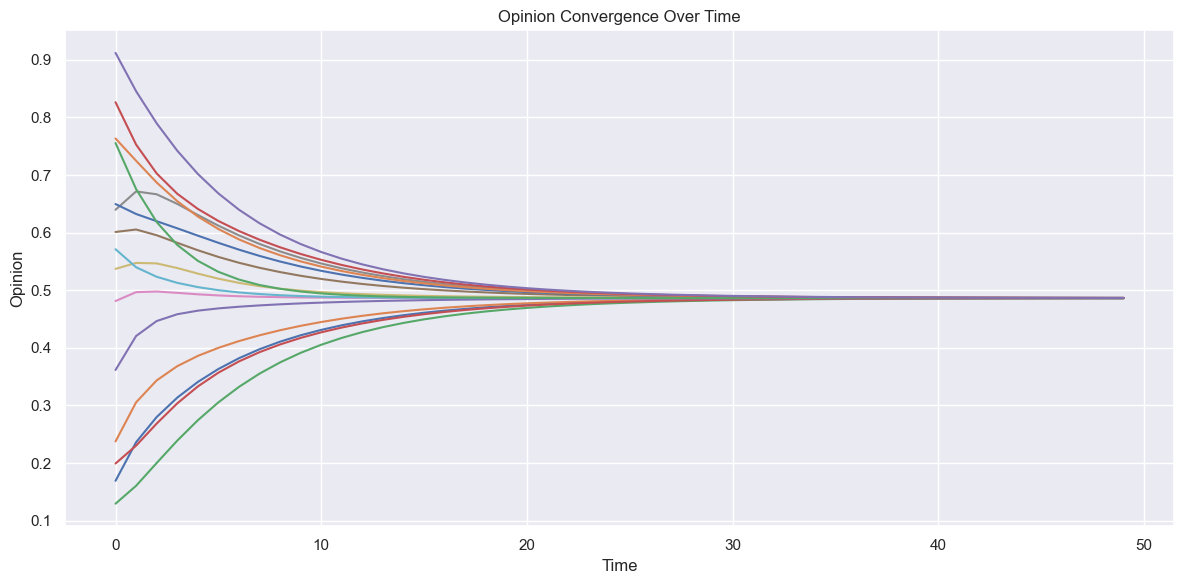

In [193]:
# Define the number of steps for which to apply the zero control input
env = init_env()

num_steps = 50

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation with zero control input
for i in range(num_steps):
    no_action_u = np.zeros(env.num_agents)  # Zero control input
    opinions, reward, done, truncated, info = env.step(no_action_u)
    opinions_over_time[i] = opinions


overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

## Broadcast Strategy (use all available budget at start)

[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
Broadcast Strategy - Overall Error: 0.4081531665919183
Final Error: 0.4107871997906066


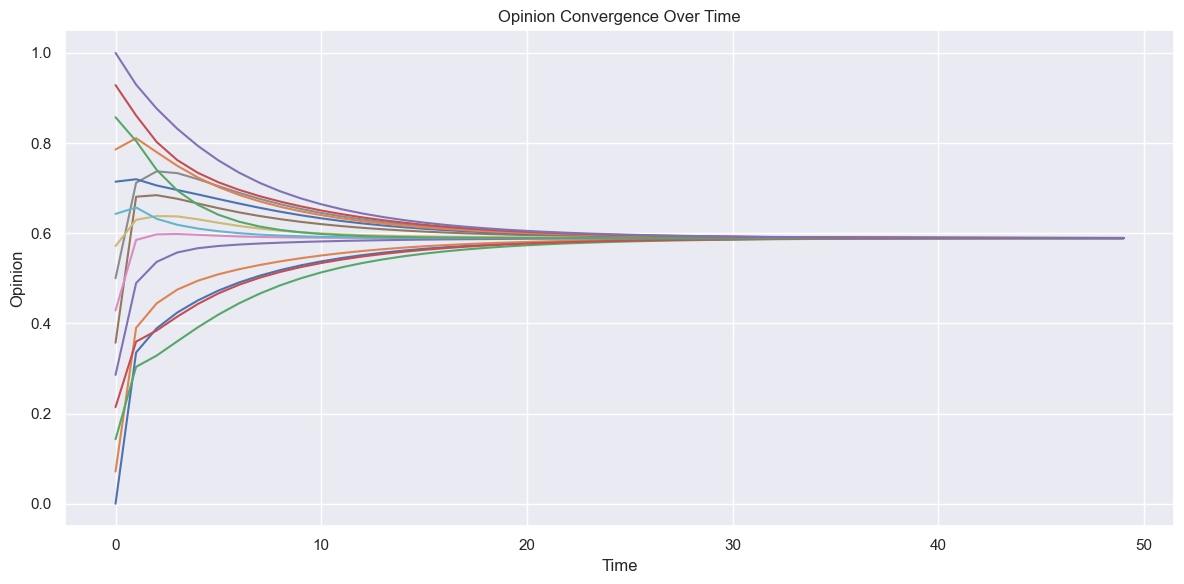

In [194]:
env = init_env()
num_steps = 50  # Total number of steps in the simulation
Q = 15  # Total budget

# Run the experiment with the broadcast strategy
opinions_over_time_broadcast, budget_distribution, affected_nodes = (
    run_broadcast_strategy(env, Q, num_steps)
)
overall_error_broadcast = compute_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)
final_error_broadcast = compute_final_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)

print(f"Broadcast Strategy - Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time_broadcast)

### Broadcast with single step

[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
Broadcast Strategy - Overall Error: 0.45539483851362145
Final Error: 0.41078967702724306


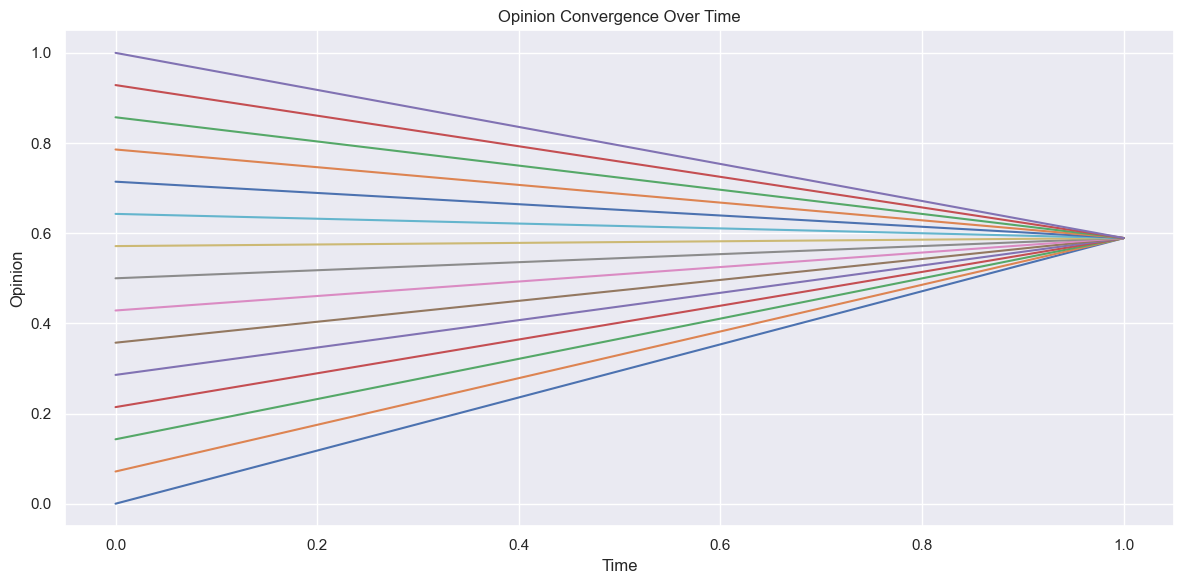

In [195]:
env = init_env()
num_steps = 50  # Total number of steps in the simulation
Q = 15  # Total budget

opinions_over_time = np.zeros((2, env.num_agents))

# Lists to store budget distribution and affected nodes
budget_distribution = []
affected_nodes = []

# Store opinions before applying the first control step
opinions_over_time[0] = env.opinions.copy()

# Calculate the control action using the total budget (units of u_max)
optimal_action, remaining_budget, controlled_agents = optimal_control_action(env, Q)
print(optimal_action)

# Apply the control for the first step
opinions, reward, done, truncated, info = env.step(
    optimal_action, step_duration=0.5 * num_steps
)
opinions_over_time[1] = opinions

# Track affected nodes and budget
affected_nodes.append(list(np.where(optimal_action > 0)[0]))
budget_distribution.append(np.sum(optimal_action))  # Budget used in the first step

overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Broadcast Strategy - Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

Broadcast Strategy with Sampling - Overall Error: 0.40876695413471553
Final Error: 0.41079180392724574


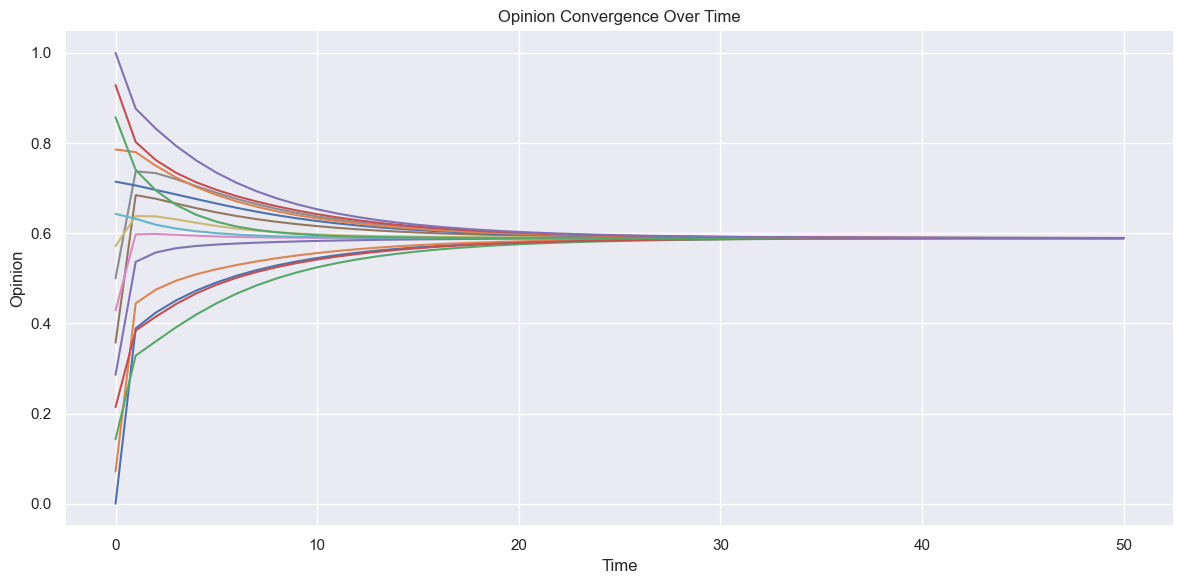

In [196]:
env = init_env()
num_steps = 50  # Total number of steps in the simulation

# Parameters
Q = 15  # Total budget (units of max_u)
step_duration = 0.5 * num_steps  # Total duration over multiple steps
sampling_time = 0.5


# Determine the control action using the total budget (units of max_u)
optimal_action, remaining_budget, controlled_agents = optimal_control_action(env, Q)

# Run the campaign with sampling
opinions_over_time, time_points = run_campaign_with_sampling(
    env,
    action=optimal_action,
    step_duration=step_duration,
    sampling_time=sampling_time,
)

# Compute errors
overall_error = compute_average_error(opinions_over_time, env.desired_opinion)
final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

print(f"Broadcast Strategy with Sampling - Overall Error: {overall_error}")
print(f"Final Error: {final_error}")
plot_opinions_over_time(opinions_over_time)

### DP

In [197]:
from algos import dynamic_programming_strategy, extract_optimal_policy, compute_expected_value_for_budget_distribution

env = init_env()
M = 4
Q = 15
step_duration = 30

(
    policy,
    Xgrid,
    V,
) = dynamic_programming_strategy(env, M, Q, step_duration)

optimal_budget_allocation, nodes_controlled, control_inputs, final_opinion_error, X = extract_optimal_policy(
    policy, env, Xgrid, V, M, Q, step_duration
)
print(optimal_budget_allocation)
print(nodes_controlled)

DP step 4
DP step 3
DP step 2
DP step 1
[7, 7, 1, 0]
[array([ 0,  1,  2,  3,  6,  9, 10], dtype=int64), array([ 0,  2,  3,  9, 10, 13, 14], dtype=int64), array([2], dtype=int64), array([], dtype=int64)]


In [198]:
final_opinion_error, total_cost, costs, X = compute_expected_value_for_budget_distribution(
    optimal_budget_allocation, env, M, step_duration
)
final_opinion_error

0.3578468794241487

In [199]:
final_opinion_error, total_cost, costs, X = compute_expected_value_for_budget_distribution(
    [4, 2, 2, 7], env, M, step_duration
)
final_opinion_error

0.3457249232407684

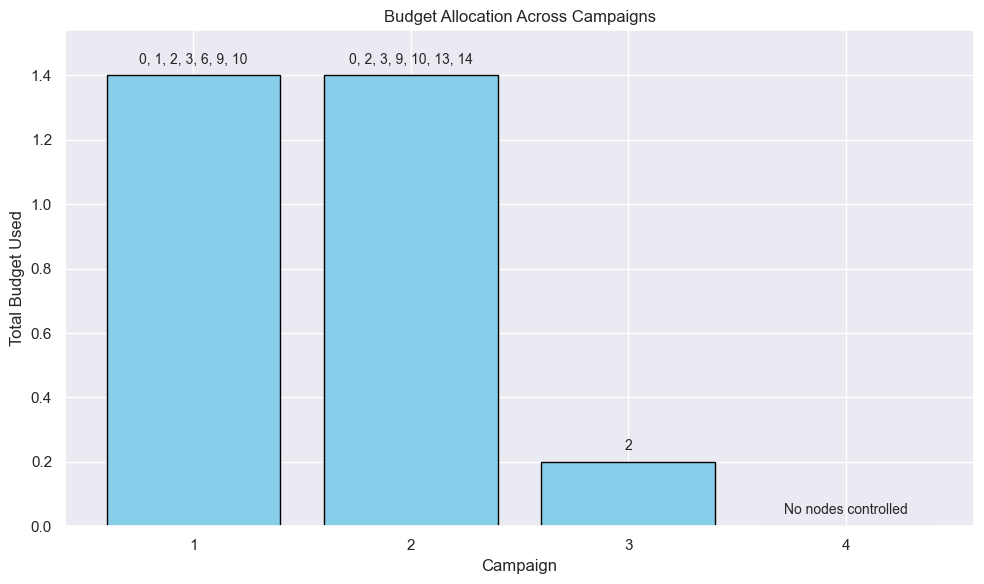

In [200]:
plot_campaign_budgets(optimal_budget_allocation, nodes_controlled, control_inputs)

Dynamic Programming Strategy - Overall Error: 0.3772246420151153
Final Error: 0.35784688770162015
[array([ 0,  1,  2,  3,  6,  9, 10], dtype=int64), array([ 0,  2,  3,  9, 10, 13, 14], dtype=int64), array([2], dtype=int64), array([], dtype=int64)]


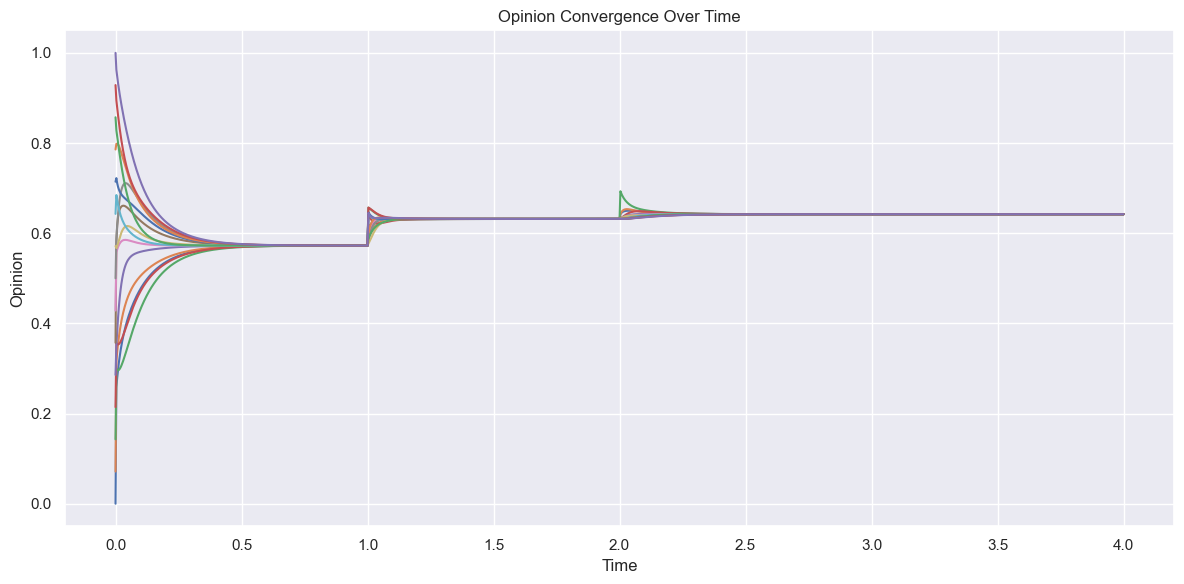

In [201]:
from algos import run_dynamic_programming_campaigns
from algos import normalize_campaign_time

env = init_env()

sampling_time = 0.1
final_campaign_step_duration = 30  # Longer duration for the final campaign
final_campaign_sampling_time = 0.1

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        optimal_budget_allocation,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

Dynamic Programming Strategy - Overall Error: 0.4041578824584153
Final Error: 0.34572493545025884
[array([0, 1, 2, 3], dtype=int64), array([ 2, 10], dtype=int64), array([ 2, 10], dtype=int64), array([ 0,  2,  3,  9, 10, 13, 14], dtype=int64)]


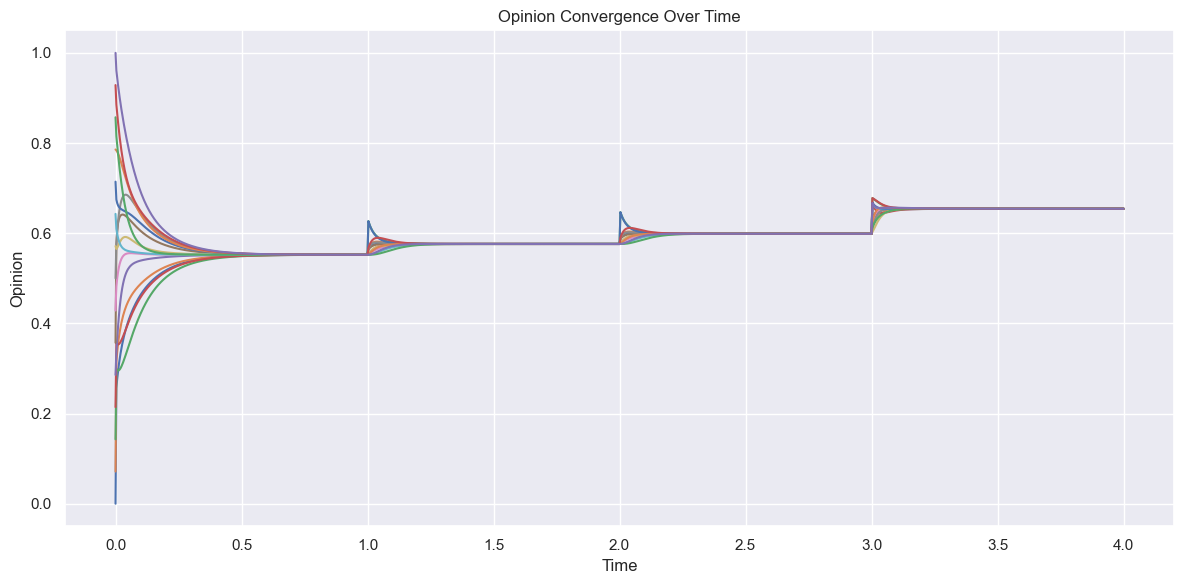

In [202]:
from algos import run_dynamic_programming_campaigns
from algos import normalize_campaign_time

handmade_budget_allocation = [4, 2, 2, 7]

env = init_env()

sampling_time = 0.1
final_campaign_step_duration = 30  # Longer duration for the final campaign
final_campaign_sampling_time = 0.1

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        handmade_budget_allocation,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

In [203]:
# ### Brute force search

# from itertools import product
# from algos import run_dynamic_programming_campaigns, compute_average_error, compute_final_average_error
# from viz import plot_opinions_over_time
# from tqdm import tqdm

# # Define parameters
# total_budget = 15
# num_campaigns = 4  # Number of campaigns
# step_duration = 30
# final_campaign_step_duration = 30  # Longer duration for the final campaign
# sampling_time = 0.1
# final_campaign_sampling_time = 0.1

# # Initialize environment
# env = init_env()

# # Function to generate all valid budget allocations
# def generate_valid_budget_allocations(total_budget, num_campaigns):
#     """Generate all budget combinations where the sum of budgets is <= total_budget."""
#     allocations = []
#     for allocation in product(range(total_budget + 1), repeat=num_campaigns):
#         if sum(allocation) <= total_budget:
#             allocations.append(allocation)
#     return allocations

# # Get all valid budget allocations
# valid_budget_allocations = generate_valid_budget_allocations(total_budget, num_campaigns)

# # Store all results: budget combination and corresponding final error
# results = []

# # Brute-force search over all budget allocations
# for budget_allocation in tqdm(valid_budget_allocations, desc="Running Campaigns"):
#     # Reset environment for each test
#     env = init_env()
    
#     # Run the campaigns using the current budget allocation
#     opinions_over_time, time_points, nodes_controlled_simulation = run_dynamic_programming_campaigns(
#         env,
#         budget_allocation,
#         step_duration,
#         sampling_time,
#         final_campaign_step_duration=final_campaign_step_duration,
#         final_campaign_sampling_time=final_campaign_sampling_time,
#     )
    
#     # Compute final error
#     final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)
    
#     # Store the result as a tuple of (budget_allocation, final_error)
#     results.append((budget_allocation, final_error))

# # Sort results by final error (ascending)
# results_sorted_by_error = sorted(results, key=lambda x: x[1])

# # Function to display top N budget combinations
# def show_top_n_budget_combinations(results_sorted, top_n=5):
#     print(f"Top {top_n} Budget Combinations by Final Error:")
#     for i in range(min(top_n, len(results_sorted))):
#         budget_allocation, final_error = results_sorted[i]
#         print(f"Rank {i+1}: Budget: {budget_allocation}, Final Error: {final_error}")

# # Display the top N budget combinations
# show_top_n_budget_combinations(results_sorted_by_error, top_n=5)

In [204]:
results_sorted_by_error

[((4, 2, 2, 7), 0.34572493545025884),
 ((4, 2, 7, 2), 0.3457249613152348),
 ((4, 7, 2, 2), 0.34572509013938985),
 ((4, 5, 4, 2), 0.34577517189598894),
 ((4, 5, 2, 4), 0.345775251671785),
 ((4, 4, 5, 2), 0.34577553935225963),
 ((4, 4, 2, 5), 0.34577566366777485),
 ((4, 2, 5, 4), 0.345775984979692),
 ((4, 2, 4, 5), 0.3457760834694505),
 ((4, 6, 3, 2), 0.345858614796952),
 ((4, 6, 2, 3), 0.3458586374858746),
 ((4, 3, 6, 2), 0.3458589549216461),
 ((4, 2, 6, 3), 0.3458589790327462),
 ((4, 3, 2, 6), 0.34585902192501256),
 ((4, 2, 3, 6), 0.3458590299326875),
 ((4, 5, 3, 3), 0.3458709933463078),
 ((4, 3, 5, 3), 0.3458717311997303),
 ((4, 3, 3, 5), 0.34587187128087427),
 ((4, 4, 4, 3), 0.3459958561317132),
 ((4, 4, 3, 4), 0.34599589853154644),
 ((4, 3, 4, 4), 0.34599628445714464),
 ((5, 6, 2, 2), 0.34670369284667546),
 ((5, 2, 6, 2), 0.34670405785587366),
 ((5, 2, 2, 6), 0.3467041284924376),
 ((5, 5, 3, 2), 0.34671605263579913),
 ((5, 5, 2, 3), 0.34671607516525693),
 ((5, 3, 5, 2), 0.3467168406

In [205]:
from algos import get_final_error_for_budget_allocation

# Define the budget allocations you want to test
budget_allocation1 = [6, 5, 2, 2]
budget_allocation2 = [4, 2, 2, 7]

# Compute the final error for each budget allocation
final_error1 = get_final_error_for_budget_allocation(
    env, M, Q, step_duration, budget_allocation1, optimize_for_final_error=True
)

final_error2 = get_final_error_for_budget_allocation(
    env, M, Q, step_duration, budget_allocation2, optimize_for_final_error=True
)

# Print the results
print(f"Budget Allocation: {budget_allocation1}, Final Error: {final_error1}")
print(f"Budget Allocation: {budget_allocation2}, Final Error: {final_error2}")

ImportError: cannot import name 'get_final_error_for_budget_allocation' from 'algos' (d:\Work\repos\RL\phd-rl-algos\dynamic_programming\opinion_dynamics\algos.py)

In [ ]:
raise NotImplementedError

NotImplementedError: 

In [ ]:
env = init_env()

# Define the number of steps for which to apply the zero control input
num_steps = 2000
k = 500  # Apply optimal control every k steps
N = 5  # Number of consecutive steps to apply optimal control
budget = 1  # Example budget

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation
for i in range(num_steps):
    if i % k == 0:
        # Apply the optimal control every k steps for N consecutive steps
        for j in range(N):
            if i + j < num_steps:
                optimal_u = optimal_control_action(env, budget=budget)
                # print(f"Applying optimal control at step {i + j}: {optimal_u}")
                opinions, reward, done, truncated, info = env.step(optimal_u)
                opinions_over_time[i + j] = opinions
        # Skip the next N-1 steps as they are already processed
        i += N - 1
    else:
        # Apply zero control input at other steps
        optimal_u = np.zeros(env.num_agents)
        opinions, reward, done, truncated, info = env.step(optimal_u)
        opinions_over_time[i] = opinions

# Plot the collected opinions over time
plot_opinions_over_time(opinions_over_time)

TypeError: optimal_control_action() got an unexpected keyword argument 'budget'

In [ ]:
env = init_env()
M = 3  # Number of campaigns
Q = 15  # Total budget

optimal_budget_allocation = brute_force_strategy(env, M, Q)
print("Optimal budget allocation:", optimal_budget_allocation)

Optimal budget allocation: [3 3 3 3]


In [ ]:
env = init_env()

# Example usage with the environment
M = 5  # Number of campaigns
Q = 20  # Total budget

optimal_budget_allocation = dynamic_programming_strategy(env, M, Q)
print("Optimal budget allocation for each campaign:", optimal_budget_allocation)

Optimal budget allocation for each campaign: [4 3 3 3 3 4]


Optimal budget allocation (brute_force): [3 3 3 3]
Brute Force Strategy - Overall Error: 6.104991006235625
Final Error: 3.3306690738754696e-15


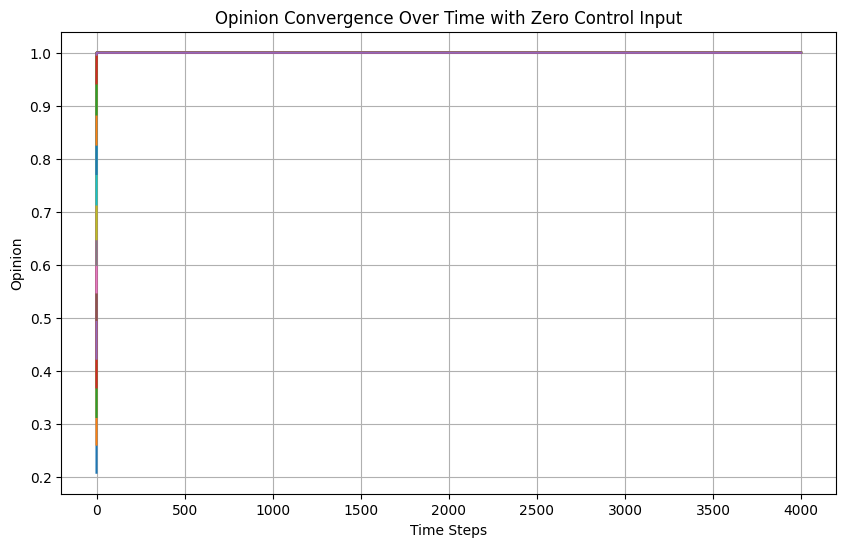

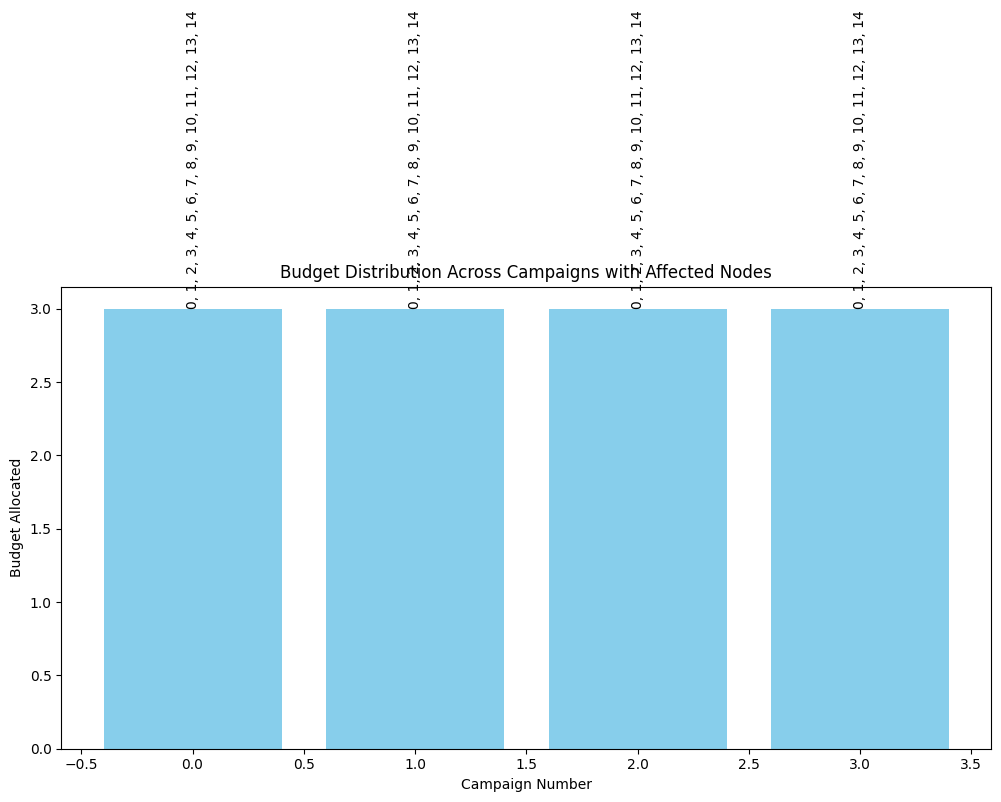

In [ ]:
# Example usage
env = init_env()
num_steps = 4000  # Total number of steps in the simulation
M = 3  # Number of campaigns
Q = 15  # Total budget
campaign_length = 0.5  # Time step

# Run the experiment with brute force strategy
opinions_over_time, budget_distribution, affected_nodes = run_experiment(
    env,
    num_steps,
    M,
    Q,
    env.tau,
    strategy="brute_force",
    campaign_length=campaign_length,
)

# Compute errors
overall_error = compute_average_error(opinions_over_time, env.desired_opinion)
final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

print(f"Brute Force Strategy - Overall Error: {overall_error}")
print(f"Final Error: {final_error}")

# Plot opinions over time
plot_opinions_over_time(opinions_over_time)

# Plot budget distribution and affected nodes
plot_budget_distribution(budget_distribution, affected_nodes)

Optimal budget allocation (brute_force): [3 3 3 3]
Brute Force Strategy - Overall Error: 18280.515590749153
Final Error: 3.168549164594347


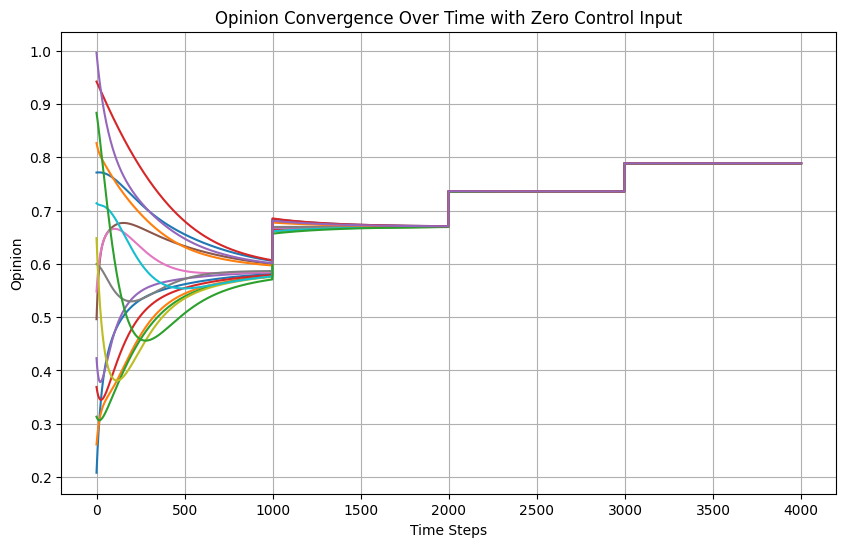

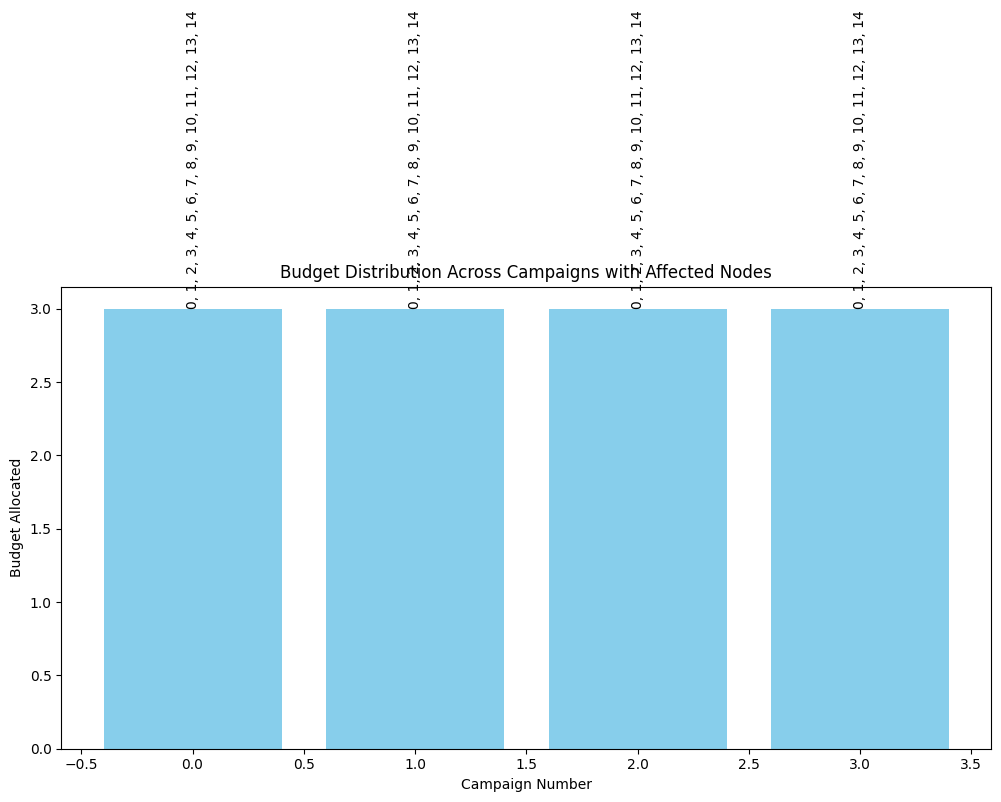

In [ ]:
# Example usage for Brute Force Strategy
env = init_env()
num_steps = 4000  # Total number of steps in the simulation
M = 3  # Number of campaigns
Q = 15  # Total budget
campaign_length = 0.5  # Campaign length in continuous time

# Run the experiment with brute force strategy
opinions_over_time, budget_distribution, affected_nodes = run_experiment(
    env,
    num_steps,
    M,
    Q,
    sample_time=env.tau,
    strategy="brute_force",
    campaign_length=campaign_length,
)

# Compute errors
overall_error = compute_average_error(opinions_over_time, env.desired_opinion)
final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

print(f"Brute Force Strategy - Overall Error: {overall_error}")
print(f"Final Error: {final_error}")

# Plot opinions over time
plot_opinions_over_time(opinions_over_time)

# Plot budget distribution and affected nodes
plot_budget_distribution(budget_distribution, affected_nodes)

Uncontrolled Case - Overall Error: 30965.272396430188
Final Error: 7.73571573387295


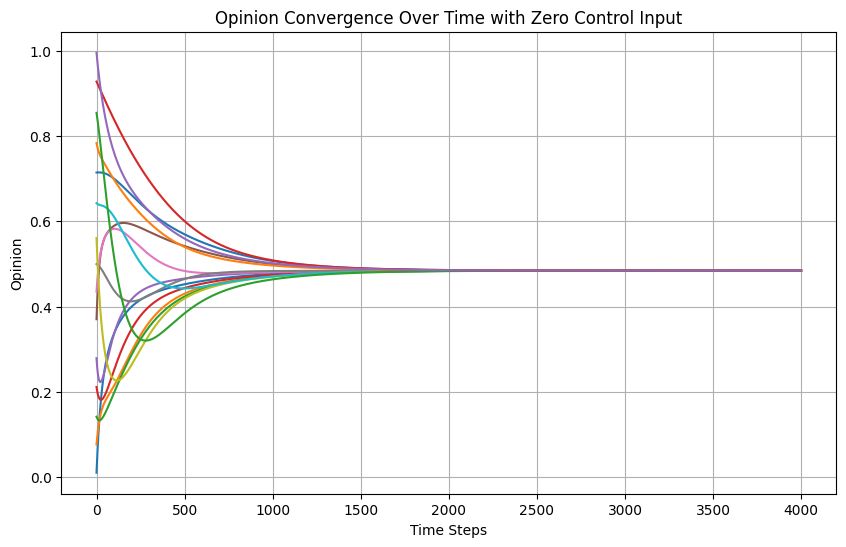

In [ ]:
# Example usage for all strategies
env = init_env()
num_steps = 4000  # Total number of steps in the simulation
M = 3  # Number of campaigns
Q = 15  # Total budget
campaign_length = 0.5  # Time step

# Run the experiment with no control (uncontrolled case)
opinions_over_time_uncontrolled = run_uncontrolled_experiment(env, num_steps)
overall_error_uncontrolled = compute_average_error(
    opinions_over_time_uncontrolled, env.desired_opinion
)
final_error_uncontrolled = compute_final_average_error(
    opinions_over_time_uncontrolled, env.desired_opinion
)

print(f"Uncontrolled Case - Overall Error: {overall_error_uncontrolled}")
print(f"Final Error: {final_error_uncontrolled}")
plot_opinions_over_time(opinions_over_time_uncontrolled)

Broadcast Strategy - Overall Error: 24772.217917144164
Final Error: 6.188572587098369


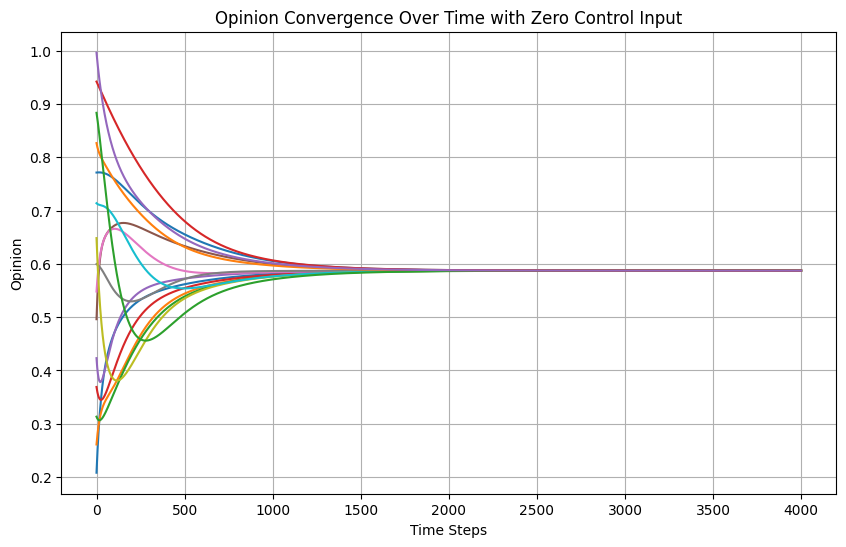

In [ ]:
env = init_env()
num_steps = 4000  # Total number of steps in the simulation
Q = 15  # Total budget
broadcast_duration = 1  # Number of steps to apply the max control input

# Run the experiment with the broadcast strategy
opinions_over_time_broadcast = run_broadcast_strategy(
    env, num_steps, broadcast_duration
)
overall_error_broadcast = compute_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)
final_error_broadcast = compute_final_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)

print(f"Broadcast Strategy - Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time_broadcast)

### Aligning with matlab version

Adjacency Matrix:
 [[0 0 1 0 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 1 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 0 0 0]]


In [ ]:
connectivity_matrix = np.array(
    [
        # 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
        [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # 1
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 2
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 3
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 4
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 5
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # 6
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],  # 7
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 8
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 9
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],  # 10
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0],  # 11
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],  # 12
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 13
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # 14
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # 15
    ]
)

np.array(adjacency_matrix) == connectivity_matrix

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  T